# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [15]:
class CTK_CRNN_Net(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTK_CRNN_Net, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [(10, 3), (3, 3)]
        pool_kernel = [(1, 1), (1, 1)]
        rnn_layer = [1]
        rnn_unit = [64]
        rnn_drop = [0]
        fc_unit = []
        drop_out = []
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[1], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - np.array(conv_kernel[0]) + 1.0) / np.array(pool_kernel[0]))
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - np.array(conv_kernel[1]) + 1.0) / np.array(pool_kernel[1]))
        
        fc_input_size = np.int(np.prod(img_size) * conv_channel[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = F.sigmoid(x)
        
        return x

In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTK_CRNN_Net(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 60 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 10 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 50,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (11, 14, 129, 60)
Single output data size: (4,)


In [21]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTK_CRNN_Net(
  (conv1): Conv2d(14, 5, kernel_size=(10, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(1, 1), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(33040, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12210080474615097 0.11084353282219833 0.12172723659092471
Train/Val/TEST Accuracy: 44.927536231884055 44.44444444444444 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10876653492450714 0.09010589060684045 0.11059820616529101
Train/Val/TEST Accuracy: 46.3768115942029 50.0 28.571428571428573
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09782210439443588 0.08735532437761624 0.10817221937967199
Train/Val/TEST Accuracy: 49.27536231884058 33.333333333333336 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09908541440963745 0.08620291503353252 0.11472976083556811
Train/Val/TEST Accuracy: 37.68115942028985 33.333333333333336 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.10305740982294083 0.08751325930158298 0.11441722898078817
Train/Val/TEST Accuracy: 46.3768115942029 33.333333333333336 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09623778909444809 0.09181037183023161 0.10911519266664982
Train

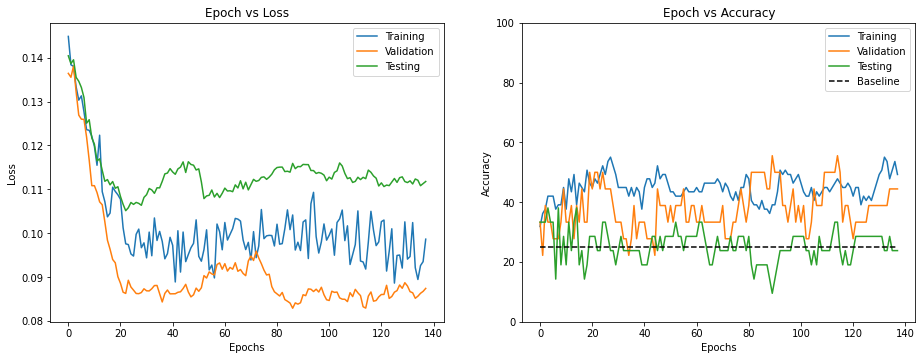

Train/Val/Test Final MSE: [0.1041723683476448, 0.0829322702354855, 0.1159191680628629]
Train/Val/Test Maximum Accuracy: [37.68115942028985, 50.0, 19.047619047619047]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12421983927488327 0.10929637795521153 0.1185321987030052
Train/Val/TEST Accuracy: 43.47826086956522 27.77777777777778 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09365746229887009 0.09117600445946057 0.10587027345207475
Train/Val/TEST Accuracy: 53.6231884057971 22.22222222222222 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08724826723337173 0.0914574819099572 0.11838684976100922
Train/Val/TEST Accuracy: 49.27536231884058 22.22222222222222 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09641102999448777 0.08893148849407832 0.1198092508351519
Train/Val/TEST Accuracy: 47.82608695652174 22.22222222222222 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09011886417865753 0.08750745447145568 0.11780661233656463
Train/Val/TEST Accuracy: 50.72463768115942 33.333333333333336 9.523809523809524
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08553335666656495 0.08810985543661648 0.1065680653389011


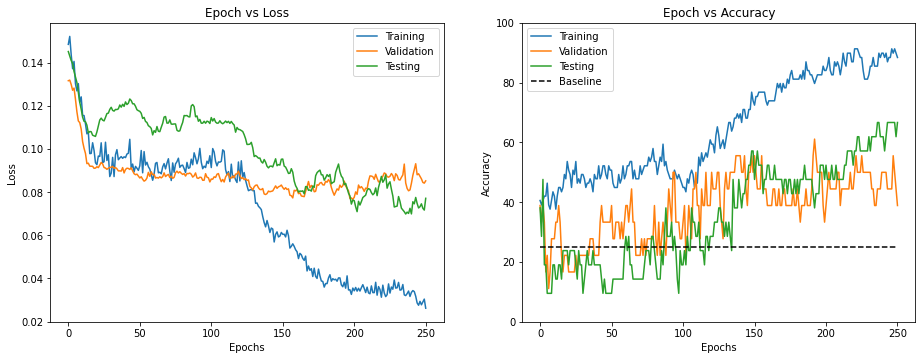

Train/Val/Test Final MSE: [0.03553641028702259, 0.07663682716277738, 0.07636393061173814]
Train/Val/Test Maximum Accuracy: [84.05797101449275, 33.333333333333336, 47.61904761904762]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11534696221351623 0.13315426996525595 0.12227533598031316
Train/Val/TEST Accuracy: 37.142857142857146 35.294117647058826 4.761904761904762
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09282609671354294 0.11566271227510537 0.11414428339118049
Train/Val/TEST Accuracy: 45.714285714285715 47.05882352941177 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08942966088652611 0.1118650322451311 0.11632563408818983
Train/Val/TEST Accuracy: 38.57142857142857 47.05882352941177 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.10444213002920151 0.11325250533135499 0.11838860073614688
Train/Val/TEST Accuracy: 38.57142857142857 52.94117647058823 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09205832779407501 0.11616152513991385 0.12309075297699087
Train/Val/TEST Accuracy: 42.857142857142854 47.05882352941177 23.80952380952381
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08995533287525177 0.11029753154691528 0.11496811049

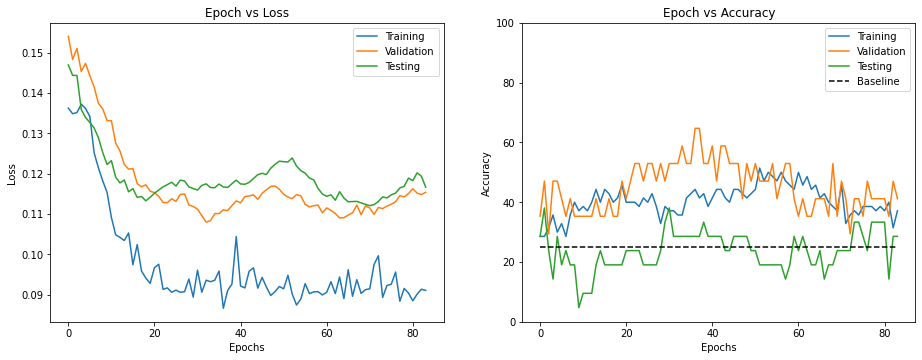

Train/Val/Test Final MSE: [0.09361206889152526, 0.10799502219785662, 0.1174804096864093]
Train/Val/Test Maximum Accuracy: [35.714285714285715, 52.94117647058823, 28.571428571428573]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12011645138263702 0.1284229536266888 0.12861861519160725
Train/Val/TEST Accuracy: 51.42857142857143 35.294117647058826 9.523809523809524
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09331793338060379 0.10527998099432272 0.10833996884702217
Train/Val/TEST Accuracy: 48.57142857142857 47.05882352941177 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08665697127580643 0.10346634028589025 0.11414871795014256
Train/Val/TEST Accuracy: 52.857142857142854 41.1764705882353 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0820387177169323 0.1029843646375572 0.11795247350597665
Train/Val/TEST Accuracy: 52.857142857142854 52.94117647058823 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08257997035980225 0.10703517923898556 0.11540441312605426
Train/Val/TEST Accuracy: 52.857142857142854 41.1764705882353 19.047619047619047
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.07679991275072098 0.10475423340411748 0.11159153495516

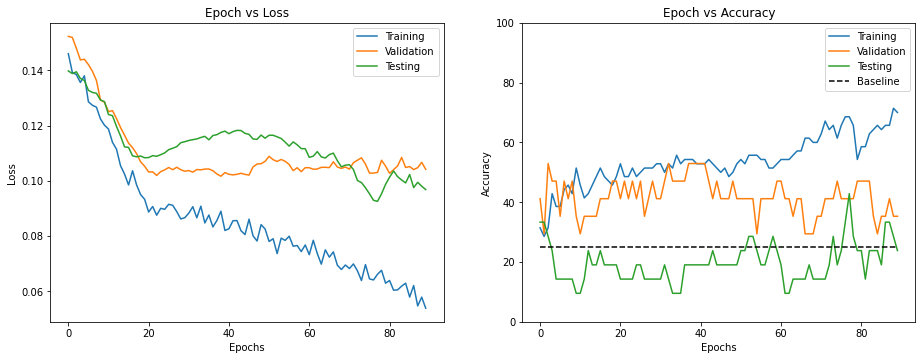

Train/Val/Test Final MSE: [0.08899495303630829, 0.10166134981109816, 0.11748995450103566]
Train/Val/Test Maximum Accuracy: [54.285714285714285, 52.94117647058823, 19.047619047619047]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12260168939828872 0.14744185700136073 0.12311555711286408
Train/Val/TEST Accuracy: 31.428571428571427 29.41176470588235 19.047619047619047
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09371955394744873 0.11628864705562592 0.11286641284823418
Train/Val/TEST Accuracy: 40.0 47.05882352941177 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.08522725850343704 0.11087025241816745 0.11055418409939323
Train/Val/TEST Accuracy: 41.42857142857143 47.05882352941177 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08755820989608765 0.1149985308156294 0.11024486694839739
Train/Val/TEST Accuracy: 44.285714285714285 47.05882352941177 23.80952380952381
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.08451191633939743 0.11718568972804967 0.10955783742524329
Train/Val/TEST Accuracy: 50.0 41.1764705882353 19.047619047619047
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0798760250210762 0.11608529529150795 0.10787162747943685
Train/Val/TEST Accurac

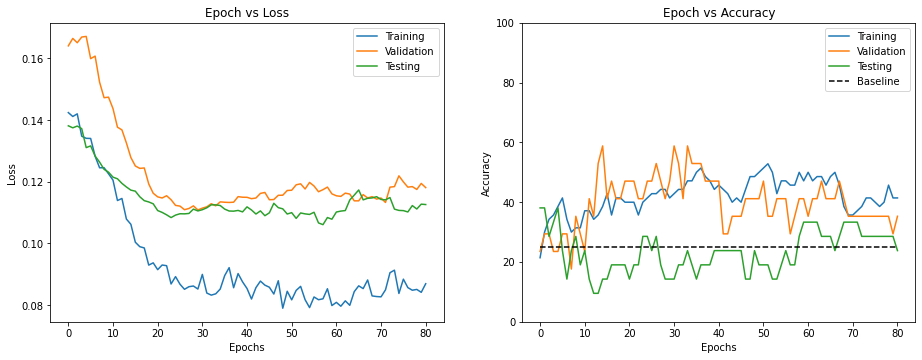

Train/Val/Test Final MSE: [0.08522725850343704, 0.11087025241816745, 0.11055418409939323]
Train/Val/Test Maximum Accuracy: [41.42857142857143, 47.05882352941177, 14.285714285714286]


In [22]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.08150861181318761, 0.09601914436507701, 0.10756152939228784]
Train/Val/Test Average Accuracy: [50.6335403726708, 47.254901960784316, 25.714285714285715]


## Single prediction results

In [24]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.25931704 0.180518   0.4505527  0.42635718] with label  [2]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.25894924998283386  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.2487053  0.17890187 0.44843313 0.47081226] with label  [3]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.2805849313735962  Accuracy: 0.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.26376992 0.2787788  0.42887956 0.5012081 ] with label  [3]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.15895962715148926  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.25818205 0.18783732 0.4485662  0.44887128] with label  [3]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.052534326910972595  Accuracy: 100.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.24063751 0.2294464  0.44670925 0.4388334 ] with